# EfficientNet-V2 L (480x480 white padding)

In [1]:
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2 as cv
import seaborn as sns
from itertools import chain
from sklearn.preprocessing import label_binarize
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple
import random
import torch
from torchvision.transforms import ToTensor
from urllib.request import urlopen
import timm
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
lr = 0.0001
train_test_ratio = 0.9
num_epochs = 300

In [3]:
imagefolder = "C:/Users/User/images/480_white/"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Меняем на EfficientNet-V2 L
model = timm.create_model(
    'tf_efficientnetv2_l.in21k_ft_in1k',
    pretrained=True,
    features_only=True,
)

model = model.to(device)
model.eval()
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

def extract_features(images):
    with torch.no_grad():
        outputs = model(images)
        last_feature_map = outputs[-1]
        features = last_feature_map.view(last_feature_map.size(0), -1)
        return features

dataset = ImageFolder(imagefolder, transform=transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

sample_images, _ = next(iter(dataloader))
sample_images = sample_images.to(device)
sample_features = extract_features(sample_images)
feature_size = sample_features.size(1)

# Pre-allocate tensors for features and labels
num_samples = len(dataset)
X = torch.zeros(num_samples, feature_size)
y = torch.zeros(num_samples, dtype=torch.long)

start_idx = 0
for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    features = extract_features(images)
    batch_size = features.size(0)

    # Move features and labels to CPU and store them
    X[start_idx:start_idx+batch_size] = features.cpu()
    y[start_idx:start_idx+batch_size] = labels.cpu()

    start_idx += batch_size

train_size = round(train_test_ratio*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Train size is {train_size}")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

input_size = X_train.shape[1]
num_classes = len(dataset.classes)
print(f"Input feature size: {input_size}")
print(f"Number of classes: {num_classes}")

logistic_model = LogisticRegressionModel(input_size, num_classes)
logistic_model = logistic_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=lr)

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = FeatureDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = FeatureDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    logistic_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        # Move data to device
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = logistic_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Using device: cuda


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
100%|██████████████████████████████████████████████████████████████████████████████| 1039/1039 [08:08<00:00,  2.13it/s]


Train size is 29909
torch.Size([29909, 92160]) torch.Size([3323, 92160])
torch.Size([29909]) torch.Size([3323])
Input feature size: 92160
Number of classes: 7
Epoch [1/300], Loss: 1.6581, Accuracy: 75.51%
Epoch [2/300], Loss: 0.8539, Accuracy: 86.98%
Epoch [3/300], Loss: 0.6133, Accuracy: 90.44%
Epoch [4/300], Loss: 0.5013, Accuracy: 92.44%
Epoch [5/300], Loss: 0.4984, Accuracy: 93.07%
Epoch [6/300], Loss: 0.3708, Accuracy: 94.66%
Epoch [7/300], Loss: 0.3709, Accuracy: 94.93%
Epoch [8/300], Loss: 0.3301, Accuracy: 95.56%
Epoch [9/300], Loss: 0.2907, Accuracy: 96.11%
Epoch [10/300], Loss: 0.2944, Accuracy: 96.24%
Epoch [11/300], Loss: 0.2688, Accuracy: 96.62%
Epoch [12/300], Loss: 0.2477, Accuracy: 96.95%
Epoch [13/300], Loss: 0.2319, Accuracy: 97.07%
Epoch [14/300], Loss: 0.2219, Accuracy: 97.33%
Epoch [15/300], Loss: 0.2035, Accuracy: 97.55%
Epoch [16/300], Loss: 0.1825, Accuracy: 97.83%
Epoch [17/300], Loss: 0.1889, Accuracy: 97.66%
Epoch [18/300], Loss: 0.1762, Accuracy: 97.79%
Epoc

Loss: 4.1906, Accuracy: 93.26%, ROC-AUC: 0.9856


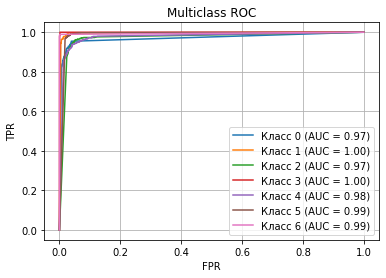

In [5]:
running_loss = 0.0
correct = 0
total = 0

all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = logistic_model(features)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)

        probs = F.softmax(outputs, dim=1)

        _, predicted = torch.max(probs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_loss = running_loss / total
test_acc = 100 * correct / total

# Объединяем все вероятности и метки в единые массивы
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Вычисляем ROC-AUC для мультиклассовой классификации с подходом "one-vs-rest"
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%, ROC-AUC: {roc_auc:.4f}")

# Визуализация ROC кривых

num_classes = all_probs.shape[1]

# Бинаризуем метки для вычисления ROC по каждому классу
y_true_binarized = label_binarize(all_labels, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc_class = {}

# Вычисляем ROC кривые и площадь под кривой для каждого класса
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], all_probs[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])

# Строим ROC кривые для всех классов
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Класс {i} (AUC = {roc_auc_class[i]:.2f})")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Multiclass ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [6]:
logistic_model.cpu()
torch.save(logistic_model.state_dict(), 'trained_model_state_L_480_white.pt')